<a href="https://colab.research.google.com/github/EnricCruzadoCampos/CounterSeedsGO/blob/main/notebooks/APP_CONTADOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚙️ Iniciando sistema (esto tarda unos segundos)...

   📸 SUBE TU FOTO DE TRIGO AHORA


Saving Imagen de WhatsApp 2025-11-18 a las 17.44.15_3f0bc1f0.jpg to Imagen de WhatsApp 2025-11-18 a las 17.44.15_3f0bc1f0.jpg

🔍 Analizando Imagen de WhatsApp 2025-11-18 a las 17.44.15_3f0bc1f0.jpg...

0: 640x480 18 Ys, 212.1ms
Speed: 6.2ms preprocess, 212.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 480)

🌾 RESULTADO: Se han detectado 18 granos.


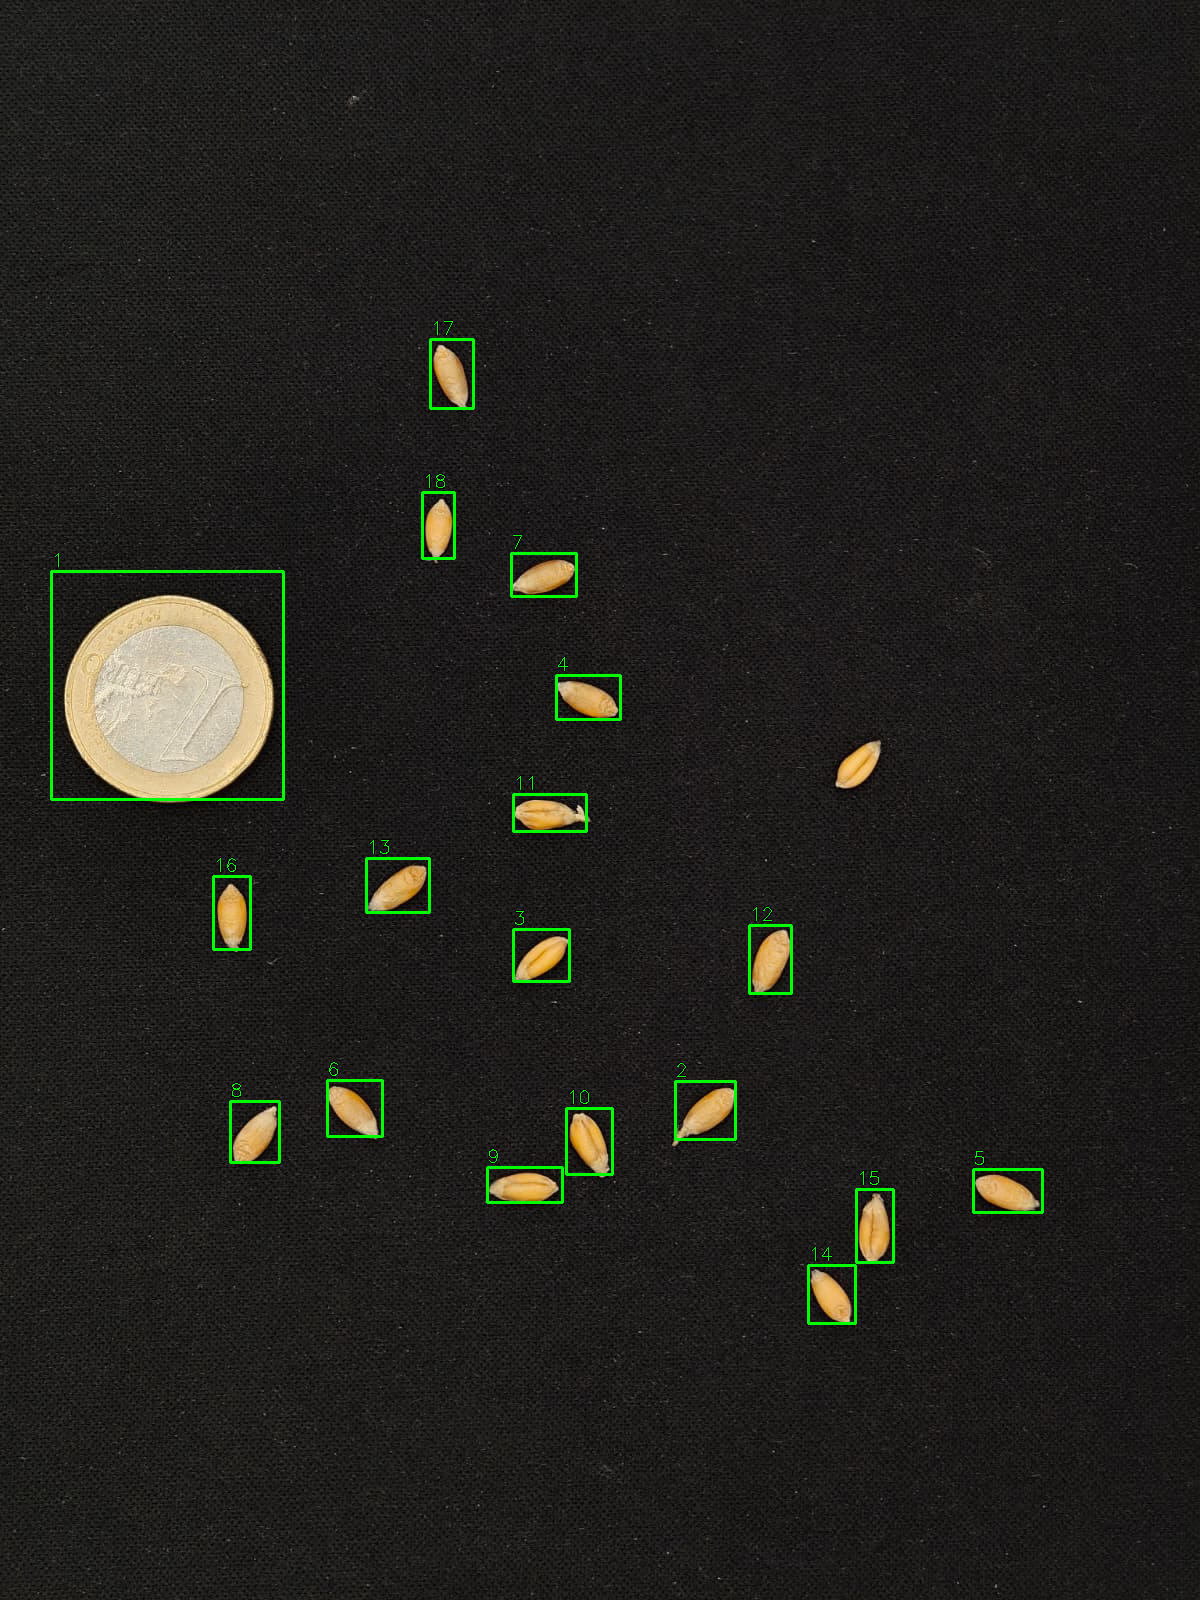

In [2]:
# @title 🌾 CONTADOR DE TRIGO IA
# @markdown 1. Dale al botón de **Play** a la izquierda.
# @markdown 2. Espera a que cargue el modelo.
# @markdown 3. Sube tu foto cuando te lo pida.

import os
import cv2
import numpy as np
import urllib.request
from google.colab import files
from google.colab.patches import cv2_imshow

# --- CONFIGURACIÓN ---
USUARIO_GITHUB = "EnricCruzadoCampos"  # <--- CAMBIA ESTO
REPO_NOMBRE = "CounterSeedsGO"
# Construimos la URL "Raw" para descargar el archivo directamente
URL_MODELO = f"https://github.com/{USUARIO_GITHUB}/{REPO_NOMBRE}/raw/main/models/best.pt"

def iniciar_app():
    # 1. Instalación silenciosa de dependencias
    print("⚙️ Iniciando sistema (esto tarda unos segundos)...")
    os.system('pip install ultralytics opencv-python-headless > /dev/null')
    from ultralytics import YOLO

    # 2. Descargar Modelo desde GitHub si no está
    if not os.path.exists('best.pt'):
        print(f"⬇️ Descargando cerebro IA desde GitHub...")
        try:
            urllib.request.urlretrieve(URL_MODELO, 'best.pt')
            print("✅ Modelo cargado correctamente.")
        except:
            print("❌ ERROR: No se pudo descargar el modelo. Revisa que el nombre de usuario y repo sean correctos en el código.")
            return

    model = YOLO('best.pt')

    # 3. Interfaz de Subida
    print("\n" + "="*40)
    print("   📸 SUBE TU FOTO DE TRIGO AHORA")
    print("="*40)
    uploaded = files.upload()

    for nombre_archivo in uploaded.keys():
        print(f"\n🔍 Analizando {nombre_archivo}...")

        # Leer imagen desde memoria
        file_bytes = np.frombuffer(uploaded[nombre_archivo], np.uint8)
        img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

        # Inferencia (Detección)
        # conf=0.4 significa 40% de seguridad mínima
        results = model.predict(img, conf=0.4)

        conteo = 0

        # Dibujar resultados
        for r in results:
            for box in r.boxes:
                # Asumiendo que solo hay una clase (trigo)
                conteo += 1
                x1, y1, x2, y2 = map(int, box.xyxy[0])

                # Dibujar rectangulo verde
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                # Poner numero
                cv2.putText(img, str(conteo), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2) # Sombra negra
                cv2.putText(img, str(conteo), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 1) # Texto verde

        # Mostrar resultado final
        print(f"\n🌾 RESULTADO: Se han detectado {conteo} granos.")
        cv2_imshow(img)

        # Guardar copia
        cv2.imwrite('resultado_final.jpg', img)

# Ejecutar
if __name__ == "__main__":
    iniciar_app()